# Extended Kalman Filter 1D_Version

EKF(Extended Kalman Filter、拡張カルマンフィルタ）はガウシアンフィルタの1つです。

位置推定を行う際にも用いられます。

本ページでは、1次元の直線上でロボットがランドマークを観測しながら（拡張）カルマンフィルタで自己位置を推定します。

1次元（直線上）の移動は線形な移動です。結果的にカルマンフィルタを用いた自己位置推定と同じです。

注がある場合を除き、本ページに掲載されているコードは[MIT](https://tiryoh.mit-license.org/)ライセンスに、文章は[CC BY 4.0](https://creativecommons.org/licenses/by/4.0/deed.ja)ライセンスに基づいて公開します。


## Requirements

このコードを動作させるにはPython 3を必要とします。

## References

S. Thrun, W. Burgard and D. Fox (著), 上田 (訳): 確率ロボティクス, 毎日コミュニケーションズ, 2007

# カルマンフィルタ
カルマンフィルタはガウシアンフィルタの一つです。
ガウシアンフィルタはノイズがガウス分布に従うと仮定して、
事後信念をガウス分布として計算できるのが特徴です。

状態空間モデルにおいて、
観測値、観測方程式、状態方程式を利用して、
観測することのできない状態値を推定するための計算手法です。
予測ステップと修正ステップに分かれています。


* 予測ステップ
  * 一つ前の時刻の事後推定値から、システムのモデルを元に事前推定値を算出します。
* 修正ステップ
  * 予測ステップで得られた事前推定値を、観測情報を元に修正を加え、事後推定値を算出します。

それぞれの記号を次のように定義します。

* 状態ベクトル(状態遷移確率) : ${x}_t$
* 観測ベクトル(計測確率) : ${z}_t$
* 制御入力ベクトル : ${u}_t$
* システム雑音ベクトル : ${\epsilon}_t$
  * 平均ベクトル : $0$
  * 共分散行列 : ${R}_t$
* 観測雑音ベクトル : ${\delta}_t$
  * 平均ベクトル : $0$
  * 共分散行列 : ${Q}_t$


このとき、線形カルマンフィルタで扱うことのできる線形モデルの場合、
${A}$を状態遷移行列、
${B}$を制御行列、
${C}$を観測行列とすると、
状態空間モデルは

\begin{align}
    {x}_t &=& {A}_t {x}_{t-1} + 
    {B}_t {u}_t +  {\epsilon}_t \\
    {z}_t &=& {C}_t {x}_t + {\delta}_t
\end{align}

と表すことができます。


実際にはロボットの状態は線形ではなく、
非線形なモデルとなります。
ロボットの状態遷移確率は$g$に、計測確率は$h$に（$g,h$はともに非線形関数）従うと仮定します。
このとき、状態空間モデルは

\begin{align}
    {x}_t &=& g({u}_t, {x}_{t-1})+{\epsilon}_t \\
    {z}_t &=& h({x}_t ) + {\delta}_t
\end{align}

と表すことができます。

非線形関数は直接共分散行列を計算することができませんが、
関数を線形近似することで、カルマンフィルタの原理を適用することは可能になります。
具体的には、線形カルマンフィルタにおいて
${A}_t, {B}_t$
と計算していた行列をEKFではヤコビ行列の
${G}_t$
として、
${C}_t$
と計算していた行列をEKFではヤコビ行列の
${H}_t$
として計算します。
ガウス分布では事後信念の平均値$\mu_{t-1}$が最尤な値となるので、
ヤコビ行列は

\begin{align}
    {G}_t &:=& g'({u}_t,{\mu}_{t-1}) &:=& \frac{\partial g({u}_t,{\mu}_{t-1})}{\partial {x}_{t-1}} \\
    {H}_t &:=& h'({\mu}_t) &:=& \frac{\partial h({\mu}_t)}{\partial {x}_{t}}
\end{align}

として定義します。
状態空間モデルを元に、予測ステップと修正ステップを行います。

$g,h$ともに非線形であり、共分散行列を直接求めることができません。
テイラー展開によって線形近似することで、線形カルマンフィルタと同様に予測ステップと修正ステップを繰り返し、
システムを推定・制御することが可能になります。

このJupyter Notebookではロボットの移動をシミュレーションしながら、位置推定を行っていきます。
移動のシミュレーションにはJupyter Notebookでグラフを描画するためのコードが読み書きできる必要があります。
Jupyter Notebookを使ってグラフ描画機能でアニメーションを表示する手法についてまとめたJupyter Notebookは[こちら](https://github.com/Tiryoh/probrobo_note/blob/master/animate_robot_motion.ipynb)です。

# モジュールのインポート

Jupyter Notebookに必要な各種モジュールをインポートします。

In [1]:
# 数値計算及び描画に必要なモジュール
import numpy as np
import math, random
from copy import copy
from matplotlib import pyplot as plt

# アニメーション作成・表示に必要なモジュール
from matplotlib import animation
from IPython.display import HTML

# ランドマーククラス
ロボットにとって目印となるランドマークを宣言します。
ロボットはこのランドマークの座標をあらかじめ知っています。

In [2]:
class Landmarks:
    """
    landmarks = Landmarks([x1, x2, ... , x])
    引数にランドマークのX座標とY座標を配列で指定
    """
    def __init__(self, array):
        """
        ランドマークの座標を配列で取得
        あとで計算処理しやすくするため、numpyのarrayに変換
        """
        self.positions = np.array(array)
    
    def draw(self, subplot = plt):
        """
        取得したすべてのランドマークの座標をプロット
        """
        xs = [ e for e in self.positions ]
        ys = [ 0.0 for e in self.positions ]
        subplot.scatter(xs, ys, s=600, marker='*', label='landmarks', color='orange')

# ロボットのクラス

ロボットを操作するためのクラスと、ロボットの描画のためのクラスに分かれています。
今回は説明用のグラフ描画のためのメソッド（`draw_graph`）もこれらのクラスで取り扱っています。

状態空間モデルの状態遷移確率 : $ {x}_t = g({u}_t, {x}_{t-1})+{\epsilon}_t $


## ロボットを操作するためのクラス
実際のロボットは自身の絶対座標を知るすべはありません。そのため、ロボットを操作するためのクラスではロボットの座標を把握していません。

ロボットを操作するためのクラスに与えることができるのは制御入力ベクトルの${u}_t$です。`move`メソッドに`distance`を引数として与えます。

## ロボットの描画のためのクラス
ロボットの描画のためのクラスでは、実際の位置を描画するためにロボットの座標や実際の移動距離を把握しています。

ロボットの描画のためのクラスでは実際の移動をシミュレーションします。`motion`メソッドが $x_t$ そのものです。

In [3]:
class Robot:
    """
    robot = Robot(0)
    ロボットの動作を決めるためのクラス
    ロボットは現在の自身の座標を把握できません。
    そのため、描画のための座標は別のクラスで管理します。
    """
    def __init__(self, x = 0):
        self.motion = RobotMotion(x)
        self.ekf = EKF(x, 0.09)
        self.sigma_translation_error = 0.1
    
    def move(self, distance):
        self.motion.update_pos(distance)
        # 制御入力(distance)に基づき、EKFの予測ステップを適用
        self.ekf.prediction_step(distance)
                
    def observation(self, landmarks):
        # 全てのランドマークについてロボットの現在地から観測できるか確認
        obss = self.motion.observation(landmarks)
        for obs in obss:
            # 観測結果を一つずつ使いながらEKFの修正ステップを適用
            self.ekf.update_step(obs[0].distance, landmarks.positions[obs[1]])
        return obss

    def draw(self, subplot, obss):
        self.motion.draw(subplot, obss)

    def draw_graph(self, subplot, obss):
        self.motion.draw_graph(subplot, obss)
        x = np.arange(-0.5, 8, 0.0001)
        subplot.plot(x, self.generate_gaussian(self.ekf.bel_x_prev, self.ekf.cov_x_prev), color = 'green', label='bel_x (t-1)')
        subplot.plot(x, self.generate_gaussian(self.ekf.priori_bel_x, self.ekf.priori_cov_x), color = 'blue', label='priori_bel_x')
        subplot.plot(x, self.generate_gaussian(self.ekf.posteriori_bel_x, self.ekf.posteriori_cov_x), color = 'orange', label='posteriori_bel_x')

    def generate_gaussian(self, bel, cov):
        x = np.arange(-0.5, 8, 0.0001)
        return np.exp(-(bel - x) ** 2 / (2 * cov)) / np.sqrt(2 * np.pi * cov) 

class RobotMotion:
    """
    ロボットの描画のためのクラス
    ロボットが実際にどのように動くかはこのクラスの中で決まっています。
    ロボットを操作するのはこのクラスではありません。
    """
    def __init__(self, x, sigma_translation_error = 0.1):
        """
        ロボットの座標、角度を配列で取得、保存
        あとで計算処理しやすくするため、numpyのarrayに変換
        """
        self.actual_poses = [np.array(x)]
        self.sigma_translation_error = sigma_translation_error
        
    def draw(self, subplot, obss, color = 'red',label = 'actual robot motion'):
        """
        ロボットの位置情報を元にベクトルを描画
        """
        xs = self.actual_poses[-1]
        ys = 0.0
        vxs = 0.5
        vys = 0.0
        sub_color = color
        sub_label = label
        subplot.quiver(xs, ys, vxs, vys, color = sub_color, label = sub_label)

    def draw_graph(self, subplot, obss, color = 'red',label = 'actual robot motion'):
        """
        ロボットの位置情報を元にベクトルを描画
        """
        xs = self.actual_poses[-1]
        ys = 0.0
        sub_color = color
        sub_label = label
        subplot.scatter(xs, ys, s = 100, marker = '^',color = sub_color, label = sub_label)

    def motion(self, robot_pos, distance, sigma):
        """
        ロボットを移動
        進む距離、進む角度を元に移動する先の座標をnumpyのarray形式で返す
        """
        # 移動距離に混入する雑音の大きさを設定
        # 標準偏差 : simga（update_posメソッドでは10%と指定）
        actual_distance = random.gauss(distance, distance * sigma)
        return robot_pos + actual_distance
        
    def update_pos(self, distance):
        """
        ロボットを移動し、位置情報を配列に追加
        進む距離、進む角度を元に位置情報を更新
        """
        self.actual_poses.append(np.array(self.motion(self.actual_poses[-1], distance, 0.1)))
        
    def observation(self, landmarks):
        """
        ランドマーク観測の際に使用
        観測をシミュレーションするには、ロボットとランドマークの実際の位置が必要になります。
        そのため、ロボットのクラスからロボットの描画のためのクラス（このクラス）の中にある観測用の関数を呼び出します。
        """
        obss = []
        # すべてのランドマークについて、観測できるか確認
        for i,landmark in enumerate(landmarks.positions):
            # ランドマークの観測結果を保存
            obs = Observation(landmark)
            obs.measure(self.actual_poses[-1])
            # センサの範囲内だったランドマークをリストに追加
            if obs.distance != None:
                obss.append([obs, i])

        # 観測結果をリストで返す
        return obss

# 観測のためのクラス

ランドマークを観測するためのクラスです。
ロボットの現在地からセンサの観測範囲内にランドマークがあるかどうかをチェックします。

状態空間モデルの計測確率: $ {z}_t = h({x}_t ) + {\delta}_t $

`measure`メソッドの中の`actual_distance`が $z_t$ に、`distance`が $h({x}_t )$ に該当します。

In [4]:
class Observation:
    """
    ロボットの観測モデル
    """
    def __init__(self, landmark_pos, max_range = 1.0, min_range = 0.1, sigma = 0.1):
        # ランドマークの位置を保存
        self.landmark_x = landmark_pos
        # センサの計測できる範囲を設定
        self.sensor_max_range = max_range
        self.sensor_min_range = min_range
        # センサの観測値の雑音の標準偏差
        self.sigma_obs_error = sigma
        
        # 観測できない場合は観測結果をNoneとし、観測できた場合はこの値を上書きする
        self.distance, self.direction, self.error_ellipse = None, None, None

    def measure(self, robot_pos):
        """
        センサの値を取得してセンサの観測範囲内に対象物があるかチェックする
        """
        # ロボットの位置(ロボット自身は観測不可能)を一時保存
        robot_x = robot_pos
        
        # センサの計測距離範囲内かどうか確認する
        distance = math.sqrt((robot_x - self.landmark_x) ** 2)
        if not distance < self.sensor_max_range and distance > self.sensor_min_range:
            return # 計測範囲外だった場合はNoneのまま終了
        
        # 真値に混入する雑音の大きさを設定
        # 標準偏差 : 距離に対して10%の標準偏差
        sigma_distance = distance * self.sigma_obs_error
        
        # 雑音を混ぜてセンサの値とする
        actual_distance = random.gauss(distance, sigma_distance)   
        # センサ値を保存
        self.distance = actual_distance

# カルマンフィルタのクラス

本ページでは直線上を移動するロボットの自己位置推定を行っています。
直線上の移動の場合、非線形関数を線形近似する段階がありません。一般的なカルマンフィルタと同じ計算をしています。

## 予測ステップ
予測ステップでは、1つ前の時間($t-1$)の状態を元に、
事前推定値と事前誤差共分散を求めます。
1つ前の時間($t-1$)の
事後推定値を${{\mu}}_{t-1}$
、
事後誤差共分散を${{\Sigma}_{{\bar{x}}_{t-1}}}$
と表します。
事前推定値を$\bar{{\mu}}_t$、
事前誤差共分散を${{\Sigma}_{\bar{{x}}_t}}$
とすると、

カルマンフィルタの場合は、

\begin{align}
    \bar{{\mu}}_t 
    &=& {A}_t {{\mu}}_{t-1} + {B}_t {u}_{t} \\
    {{\Sigma}_{\bar{{x}}_t}} 
    &=& {A}_t {{\Sigma}_{{{x}}_{t-1}}} {{A}_t}^T+ {R}_t
\end{align}

と表すことができます。

拡張カルマンフィルタの場合は、

\begin{align}
    \bar{{\mu}}_t 
    &=& g({u}_t, {\mu}_{t-1}) \\
    {{\Sigma}_{\bar{{x}}_t}} 
    &=& {G}_t {{\Sigma}_{{{x}}_{t-1}}} {{G}_t}^T+ {R}_t
\end{align}

と表すことができます。
なお、${G}_t$は、状態遷移確率${x}_t$を求める非線形関数$g$のヤコビ行列です。

## 修正ステップ

修正ステップでは、予測ステップを元に、カルマンゲイン、事後推定値、事後誤差共分散を求めます。
カルマンゲインを${K}_t$、
事後推定値を${\mu}_t$、
事後誤差共分散を${\Sigma}_{{x}_t}$
とすると、

カルマンフィルタの場合、

\begin{align}
    {K}_t 
    &=& {{\Sigma}_{\bar{{x}}_t}}{{C}_t}^T({C}_t {{\Sigma}_{\bar{{x}}_t}} {{C}_t}^T + {{Q}_t})^{-1} \\
    {\mu}_t 
    &=& \bar{{\mu}}_t + {K}_t ({z}_t - {{C}_t} \bar{{\mu}}_t) \\
    {{\Sigma}_{{{x}}_t}} 
    &=& (1 - {K}_t {C}_t) {{\Sigma}_{\bar{{x}}_t}} 
\end{align}

と表すことができます。

拡張カルマンフィルタの場合、

\begin{align}
    {K}_t 
    &=& {{\Sigma}_{\bar{{x}}_t}}{{H}_t}^T
    ({H}_t {{\Sigma}_{\bar{{x}}_t}} {{H}_t}^T 
    + {{Q}_t})^{-1} \\
    {\mu}_t 
    &=& \bar{{\mu}}_t + {K}_t ({z}_t - h( \bar{{\mu}}_t)) \\
    {{\Sigma}_{{{x}}_t}} 
    &=& (1 - {K}_t {H}_t) 
    {{\Sigma}_{{\bar{x}}_t}} 
\end{align}

と表すことができます。
${H}_t$ は、ロボットの計測確率 ${z}_t$ を求める非線形関数$h$のヤコビ行列です。

ここで求められた
事後推定値${\mu}_t$
と
事後誤差共分散${{\Sigma}_{{{x}}_t}}$
が、時刻$t$におけるカルマンフィルタ適用後の
事後信念です。

$K$と`kalman_gain` 、$\mu_t$ と `posteriori_bel_x` 、${\Sigma}_{{{x}}_t}$ と`posteriori_cov_x`がそれぞれ対応しています。

カルマンゲインの
${{H}_t {{\Sigma}_{{\bar{x}}_t}} {{H}_t}^T + {{Q}_t}}$
は計測予測の不確かさを表しています。
計測がより確かであれば、不確かさは小さくなり、
カルマンゲインは大きくます。
今回の環境においては、
ロボットがランドマークを観測できると、
計測の不確かさが小さくます。
EKFの修正ステップにおける修正幅が大きくなり、
事後推定値がより真のロボットの位置姿勢に近づいていきます。

In [5]:
class EKF:
    """
    EKFのクラス
    """
    def __init__(self, robot_pos, cov):
        # ロボットの雑音：ロボットのクラスで定義されている値と近いほど正確な位置予測ができる
        # ロボットの制御入力に対する雑音の標準偏差
        self.sigma_robot_translation_error = 0.1
        # ロボットの観測に対する雑音の標準偏差
        self.sigma_robot_observation_error = 0.1
        # 初回の事前推定値を計算するための事後推定値
        # 推定位置の初期位置（初期信念）
        self.posteriori_bel_x = robot_pos
        # 初回の事前誤差共分散を計算するための事後誤差共分散
        # 推定値の初期位置の分散（標準偏差**2）
        self.posteriori_cov_x = cov
        
    def prediction_step(self, distance):
        # 1つ前の時間の状態を保存
        self.bel_x_prev = self.posteriori_bel_x
        self.cov_x_prev = self.posteriori_cov_x
        # 1つ前の時間の事後推定値を元に、事前推定値を計算
        self.priori_bel_x = self.bel_x_prev + random.gauss(distance, distance * self.sigma_robot_translation_error)
        # 1つ前の時間の事後誤差共分散を元に、事前誤差共分散を計算
        self.priori_cov_x = self.cov_x_prev + self.sigma_robot_translation_error ** 2
        
        # ランドマークを観測できなかったとき用
        self.posteriori_bel_x = self.priori_bel_x
        self.posteriori_cov_x = self.priori_cov_x
        
    def update_step(self, obs, landmark):
        # カルマンゲイン
        kalman_gain = self.priori_cov_x / (self.priori_cov_x + self.sigma_robot_observation_error ** 2)
        # 事後推定値
        self.posteriori_bel_x = self.priori_bel_x + kalman_gain * (abs(landmark - self.priori_bel_x) - obs)
        #print(obs ,landmark, self.priori_bel_x, (landmark - self.priori_bel_x))
        # 事後誤差共分散
        self.posteriori_cov_x = (1 - kalman_gain) * self.priori_cov_x

# シミュレーション用コードの実行

シミュレーションを行います。

ロボットはランドマークをまたぐのでランドマークの上を通過します。

1つ前の時間の推定値（信念）を `bel_x(t-1)` として、予測ステップ後の事前推定値を `priori_bel_x` として、修正ステップ後の事後推定値を `posteriori_bel_x` として表します。

In [6]:
# 新規ウィンドウと座標軸用subplotを用意
# タイトルは個別につけるので今は指定しない
fig, (world, graph) = plt.subplots(2, sharex=True, figsize=(12, 12))

# ランドマークの座標を指定
landmarks = Landmarks([3.0, 4.0, 7.0])

# ロボットの座標を指定
robot = Robot(0)

# アニメーション作成の初期処理
# 初期処理を指定しないと、更新処理が1回分多く呼び出される
def init():
    pass

# アニメーション作成の更新処理
def update(i):
    # 座標軸用subplotの描画内容を一度クリア
    world.cla()
    graph.cla()
    # 座標軸の範囲を指定
    world.set_xlim(-0.5, 8.0)
    world.set_ylim(-0.5, 0.5)
    graph.set_ylim(0.0, 10.0)
    # ランドマークを描画
    landmarks.draw(world)
    # ロボットを移動
    robot.move(0.2)
    # 移動後の位置でランドマークを観測
    obss = robot.observation(landmarks)
    # ロボットを描画
    robot.draw(world, obss)
    robot.draw_graph(graph, obss)
    # タイトルを追加
    world.set_title("Robot Motion : frame{0:04d}".format(i))
    graph.set_title("bel")
    # 左上に凡例を追加
    world.legend(loc='upper left')
    graph.legend(loc='upper left')

# アニメーションの作成
anim = animation.FuncAnimation(fig, update, init_func=init, interval = 1000, frames = 40)

In [7]:
HTML(anim.to_html5_video())

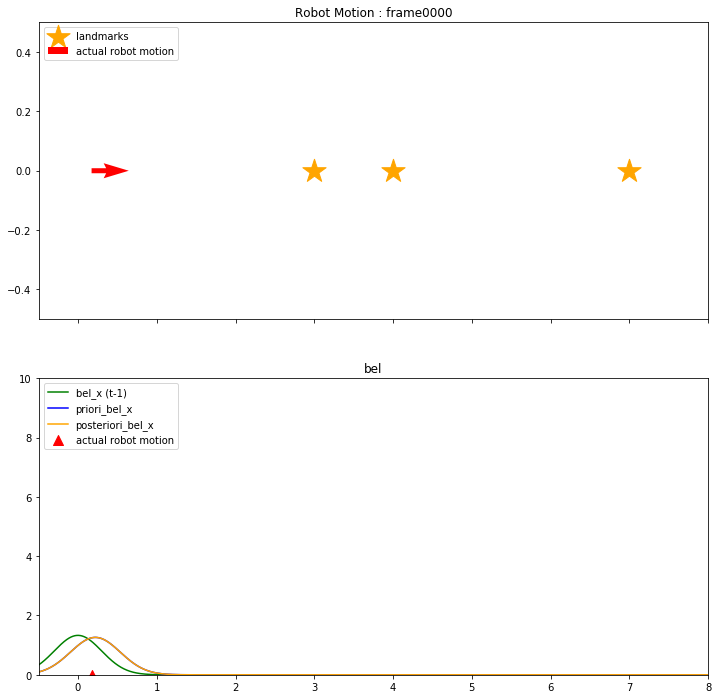

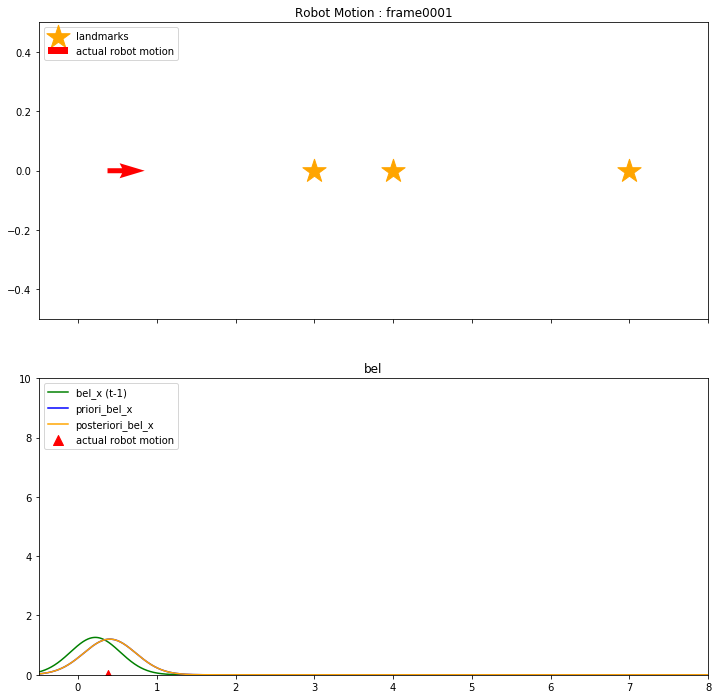

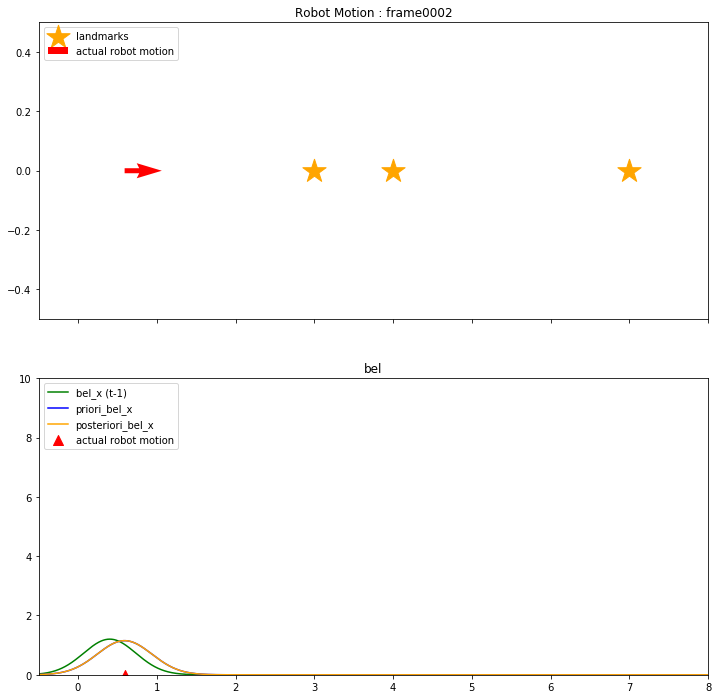

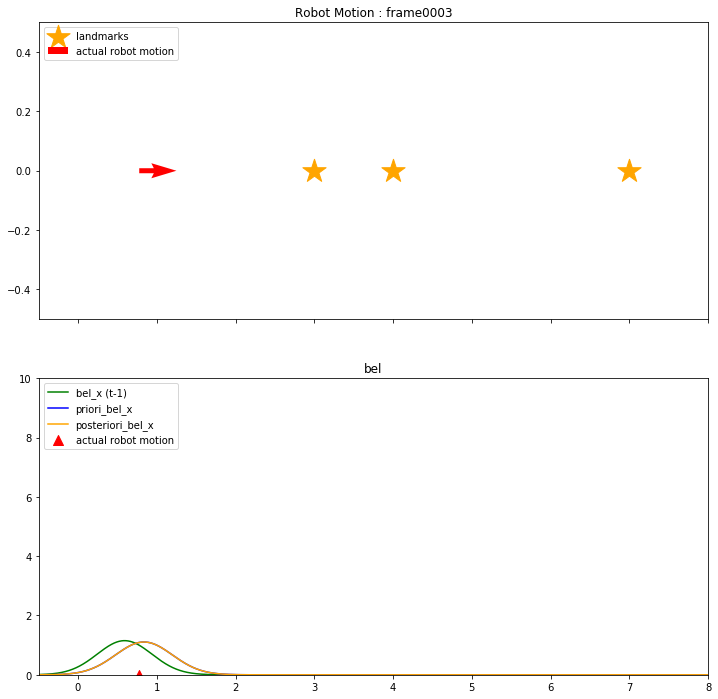

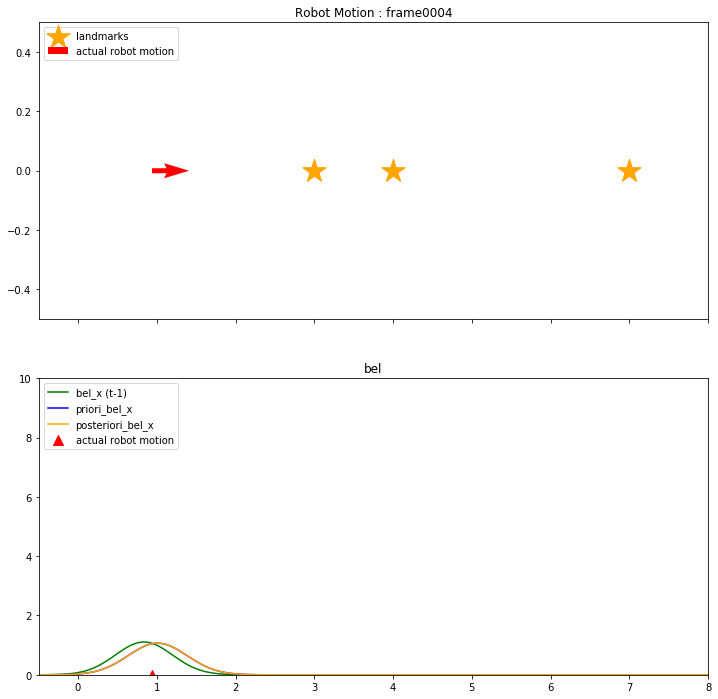

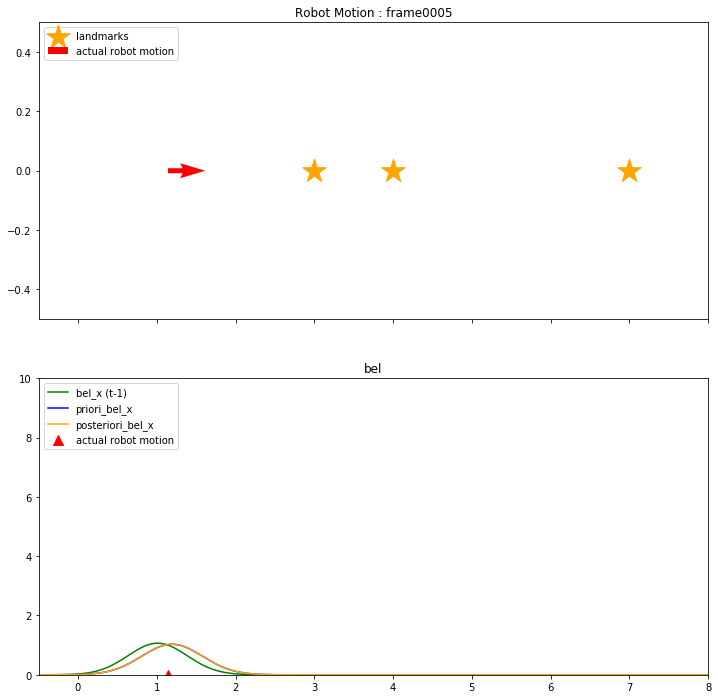

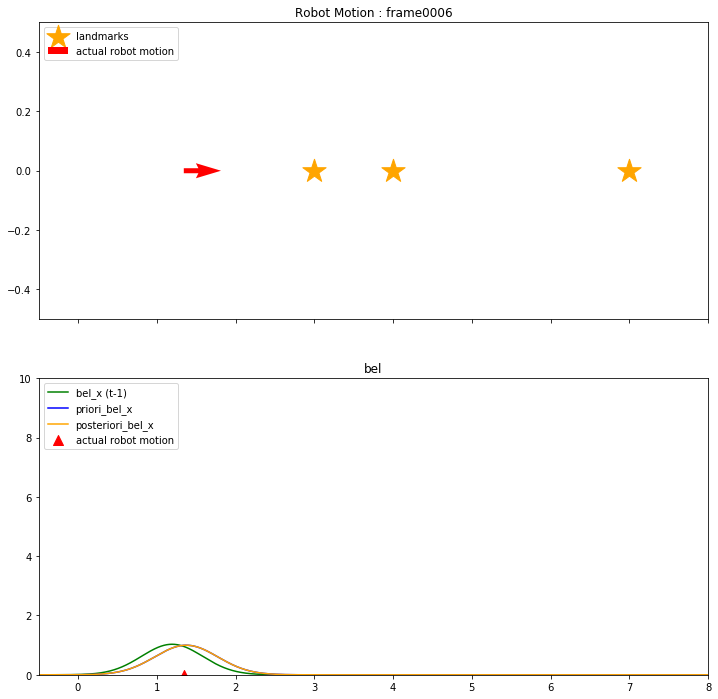

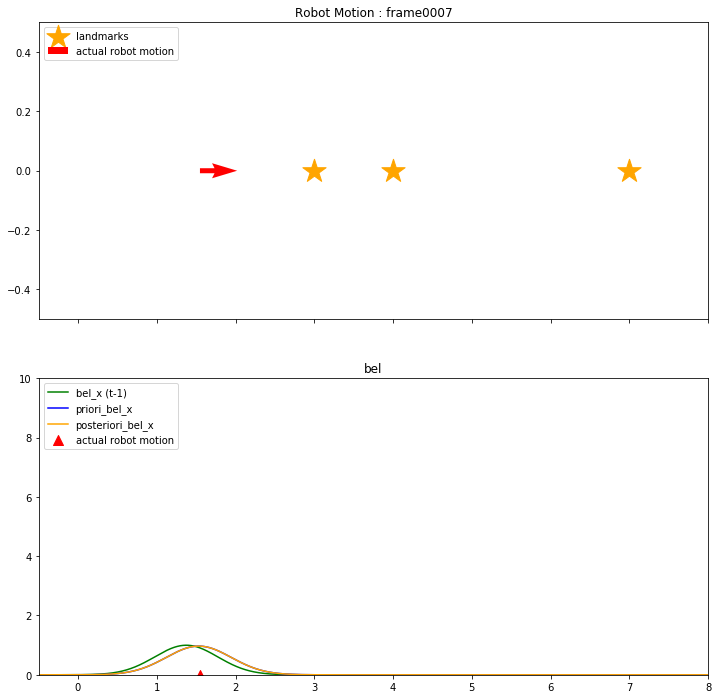

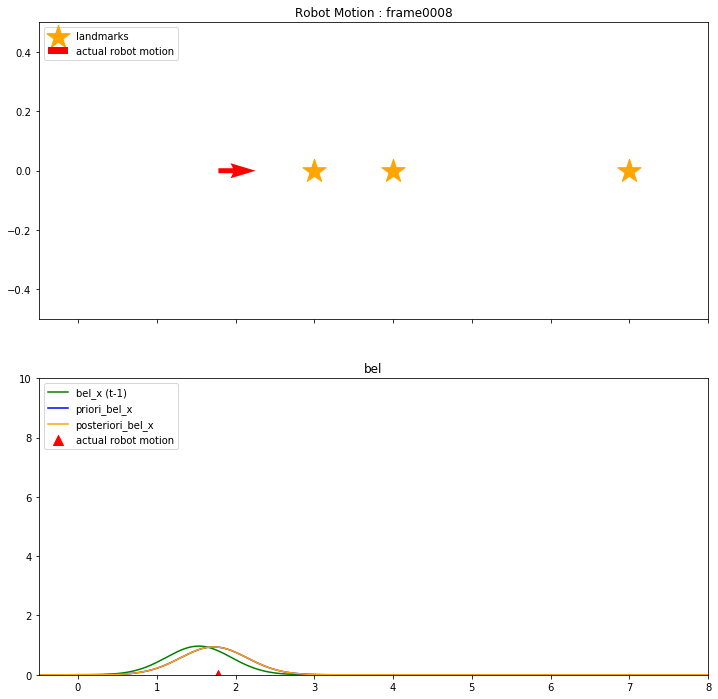

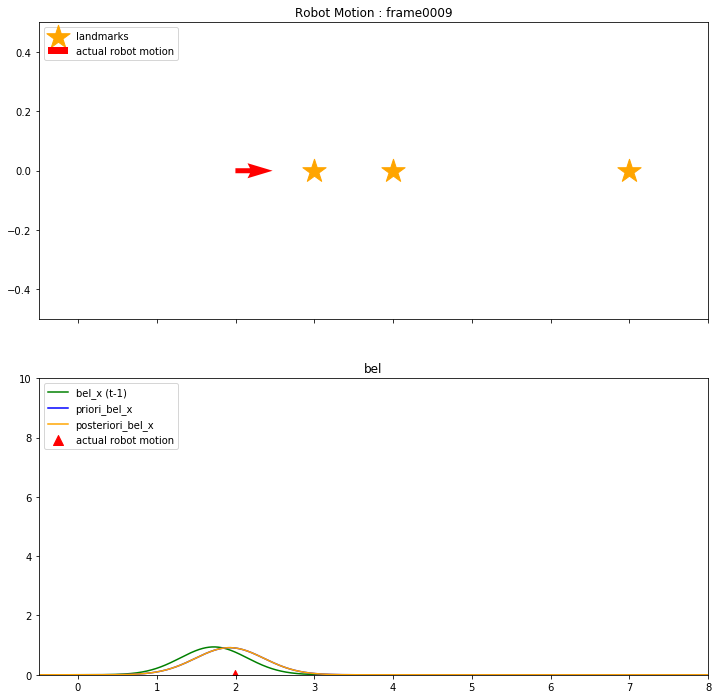

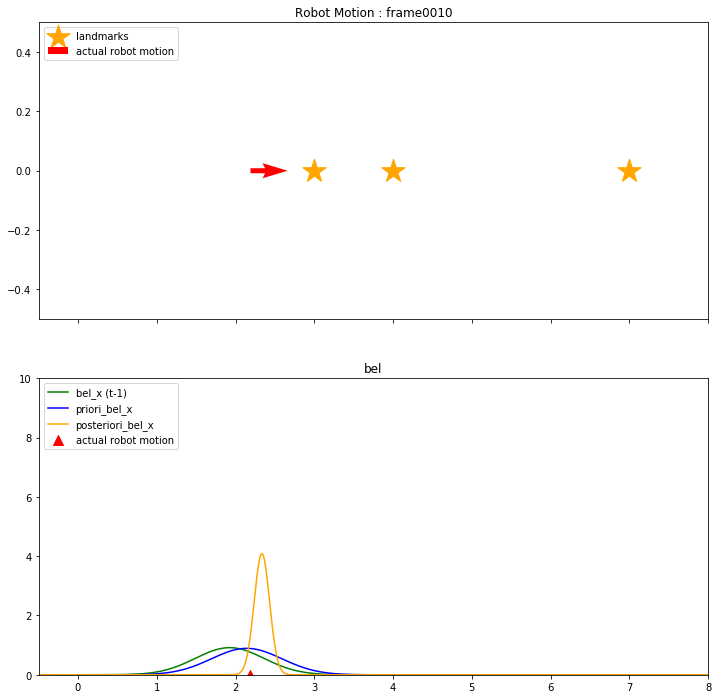

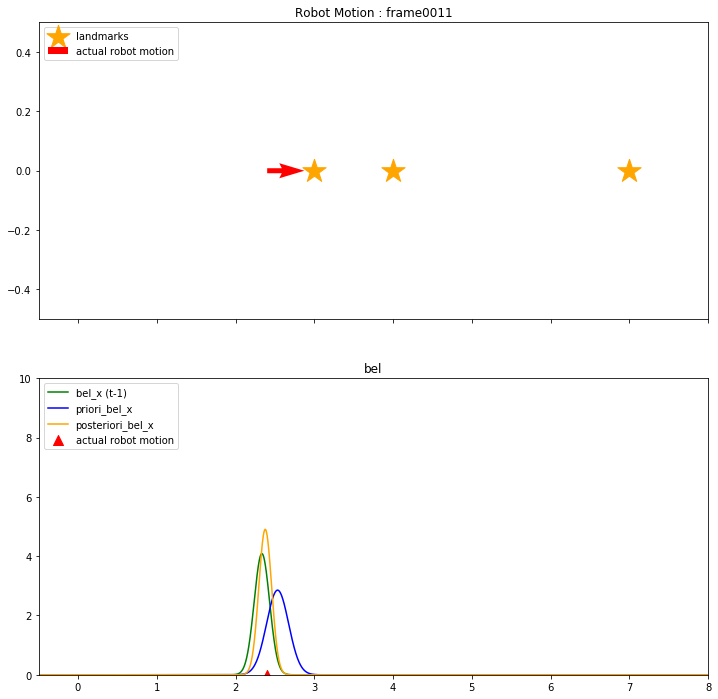

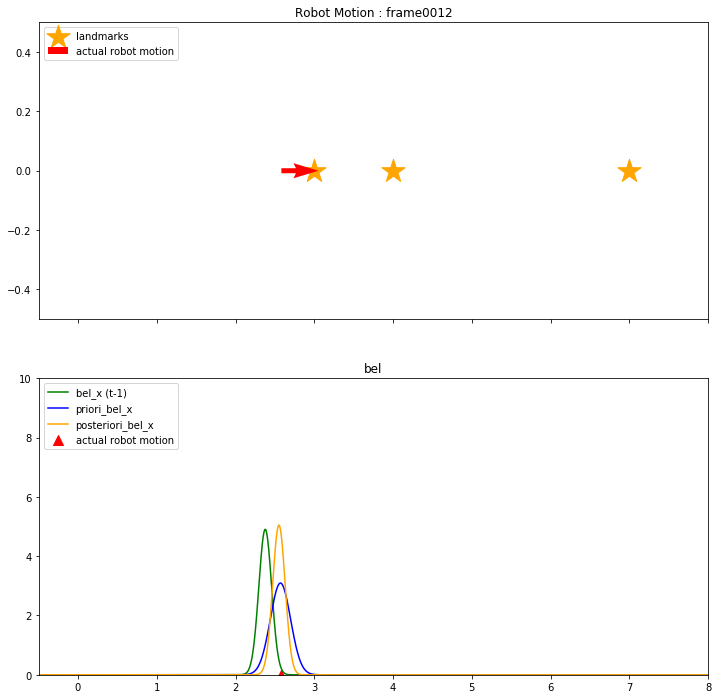

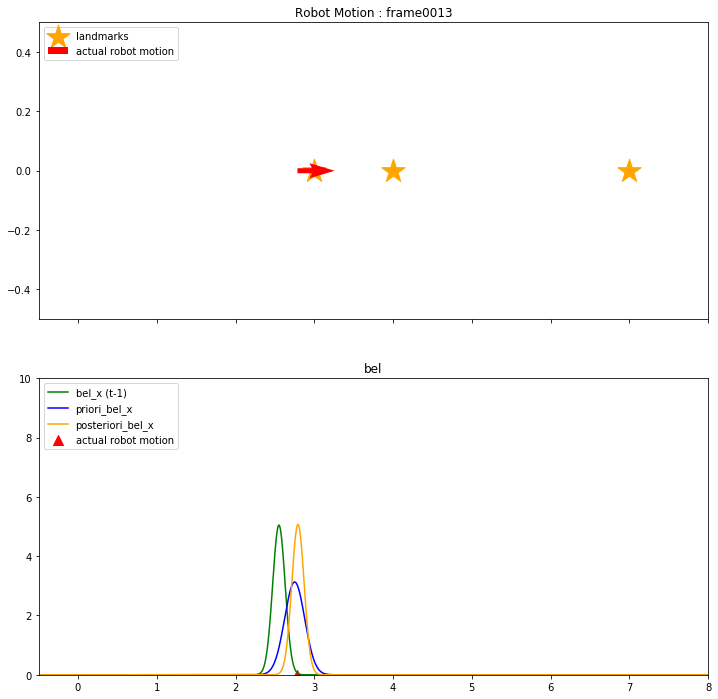

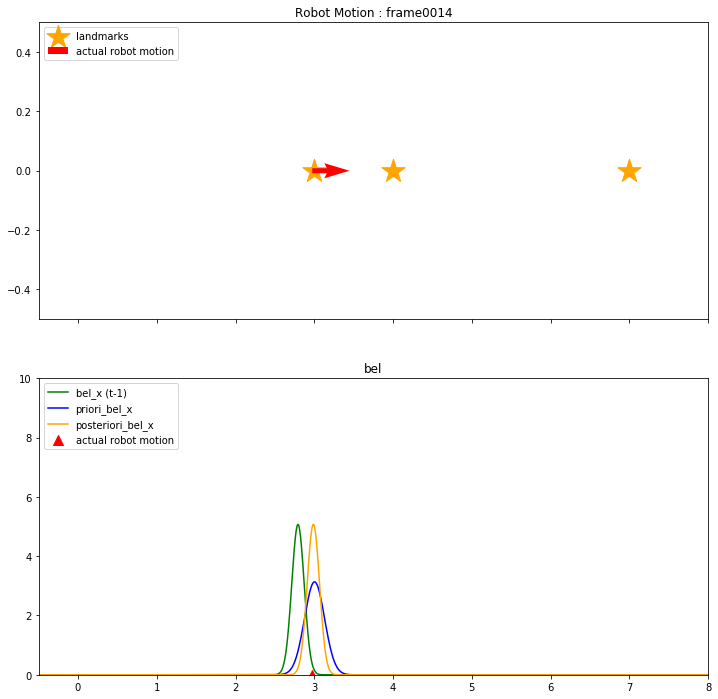

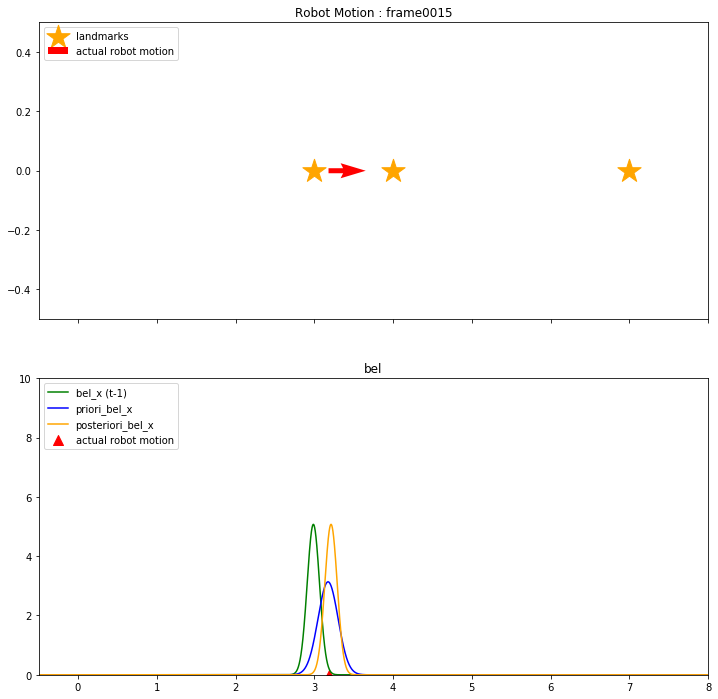

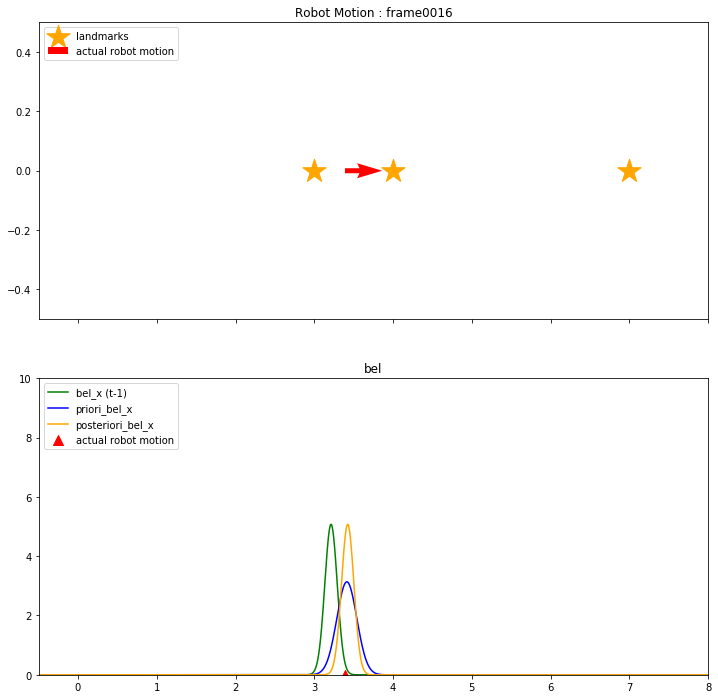

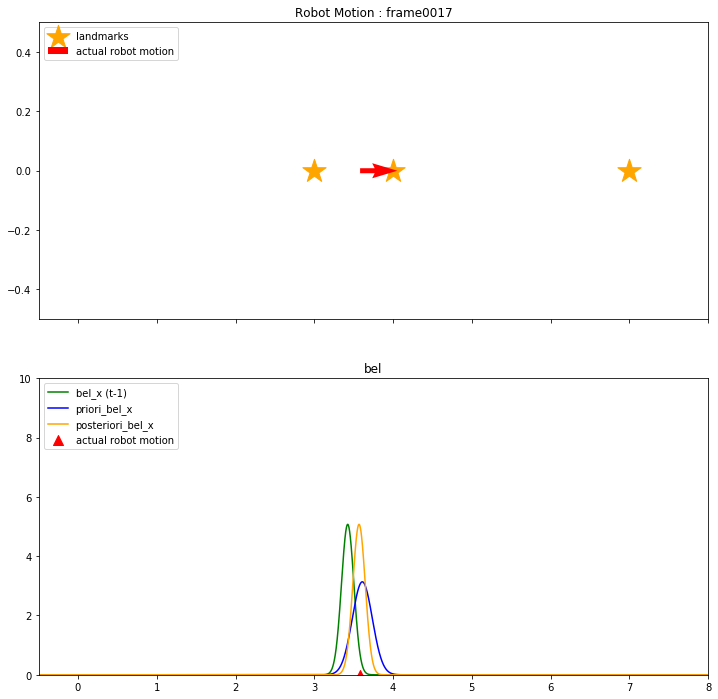

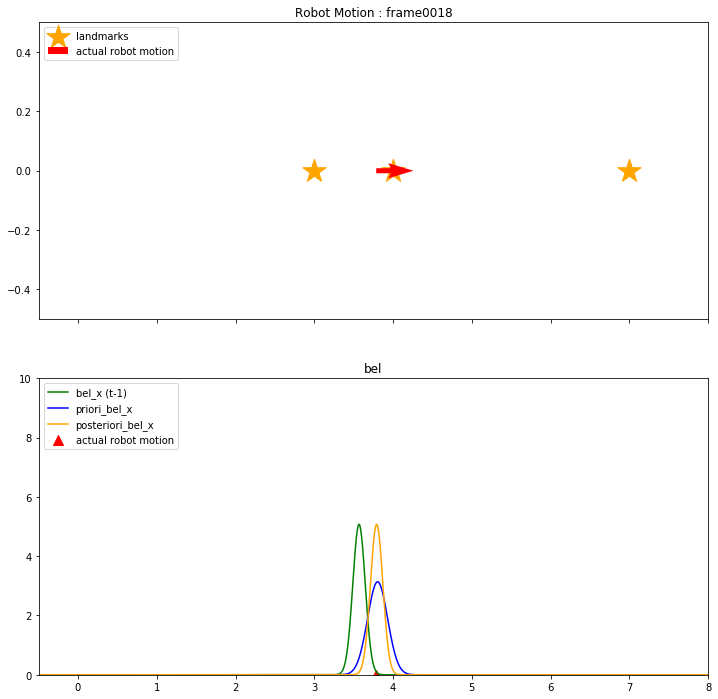

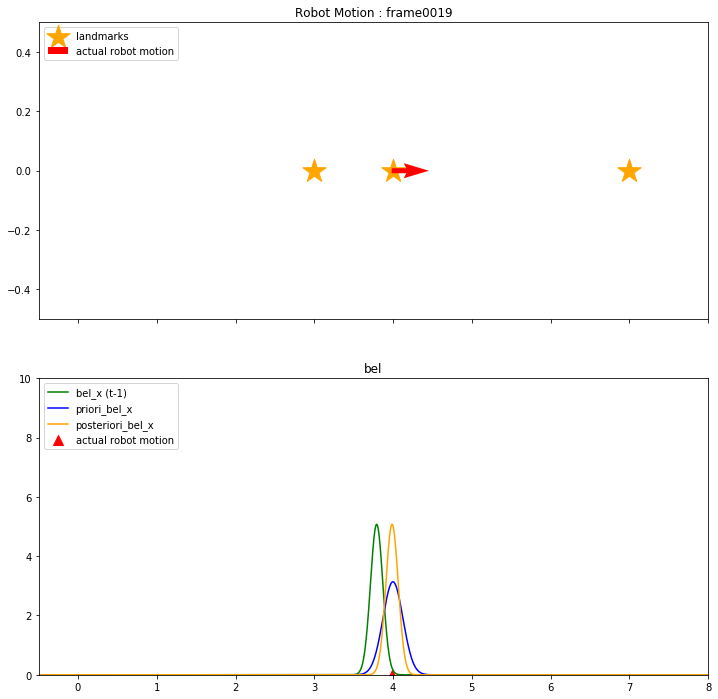

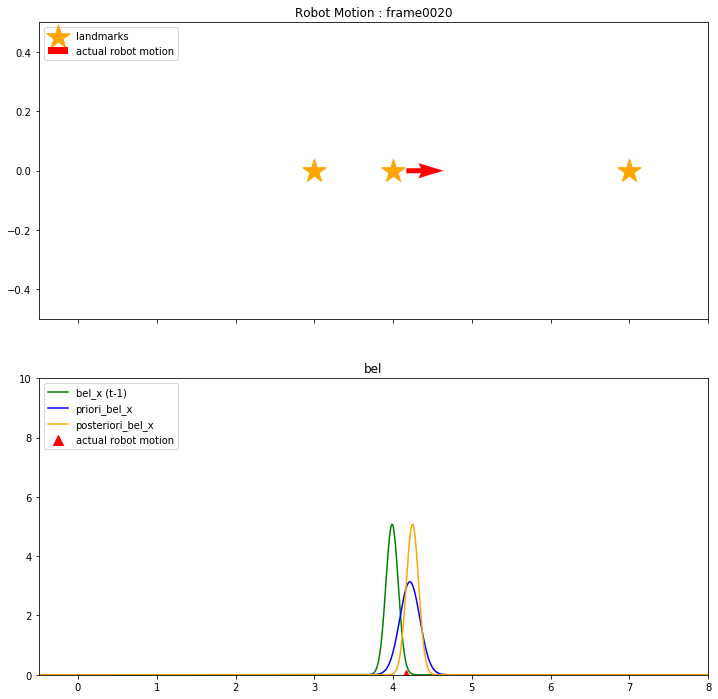

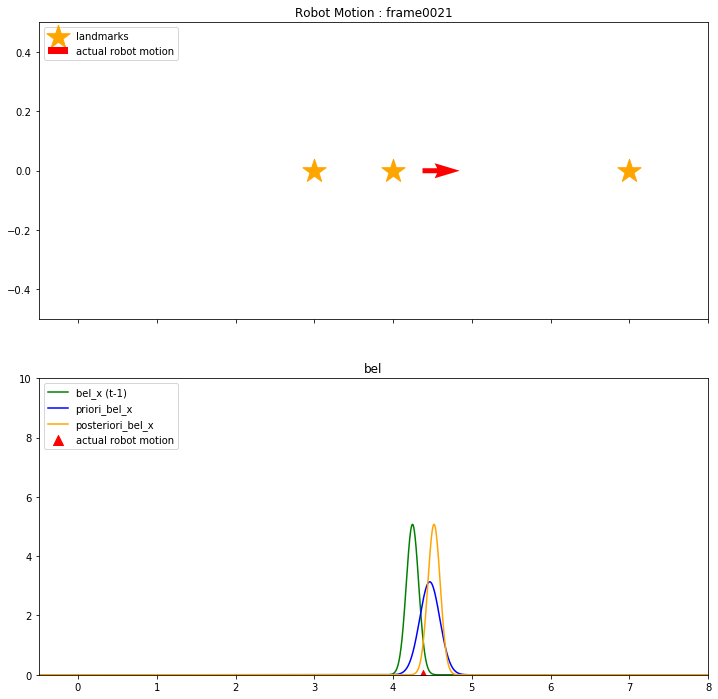

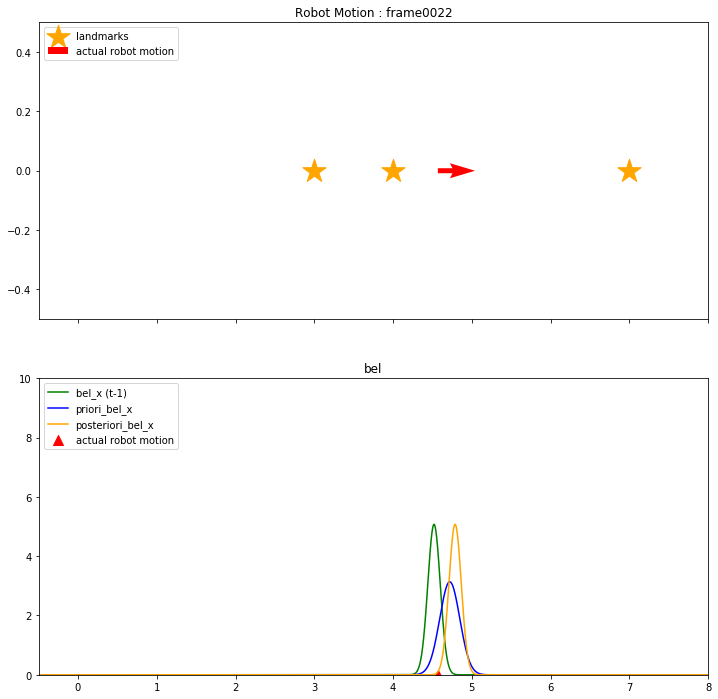

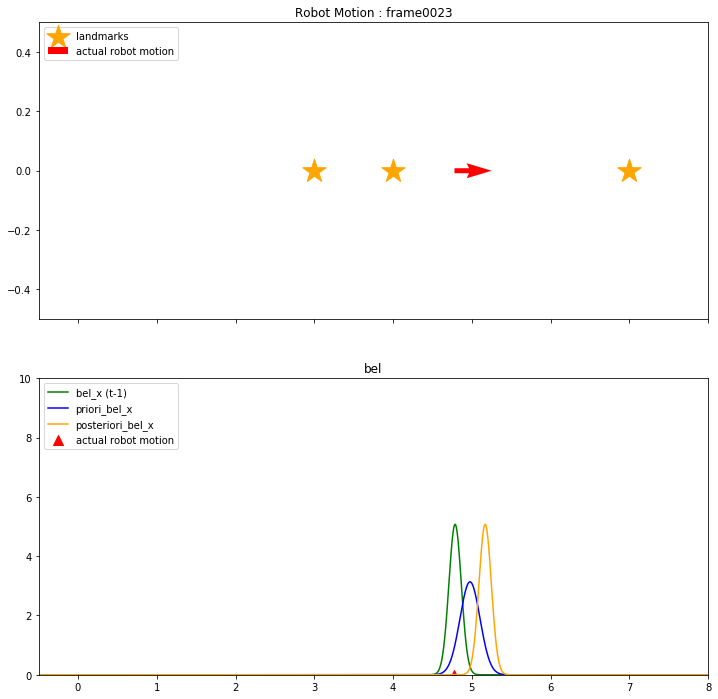

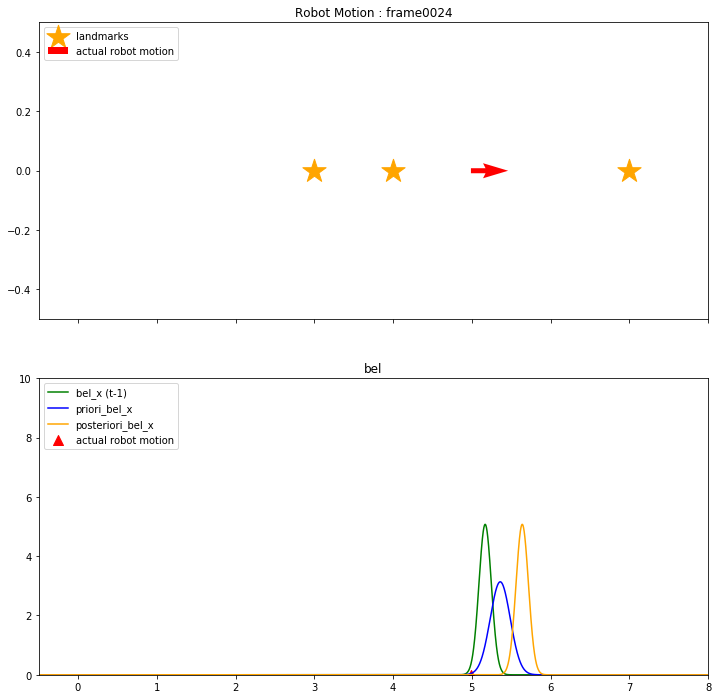

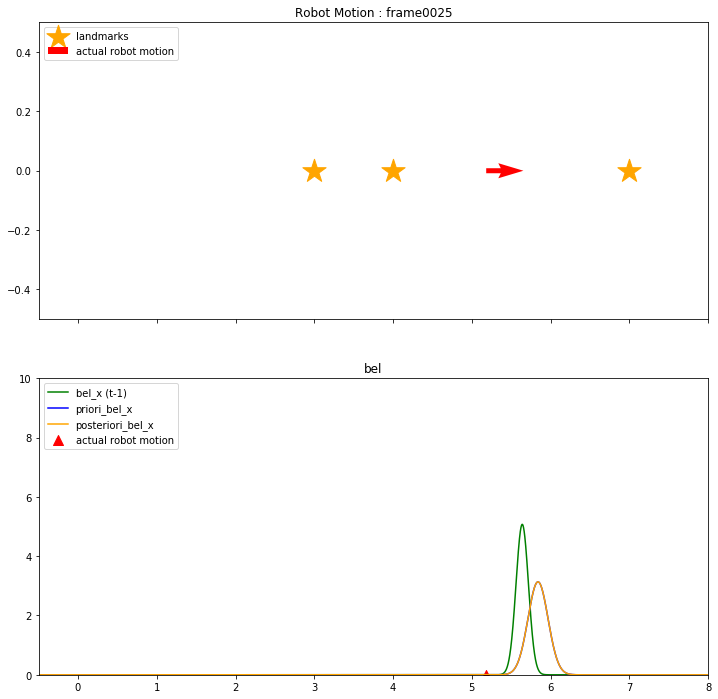

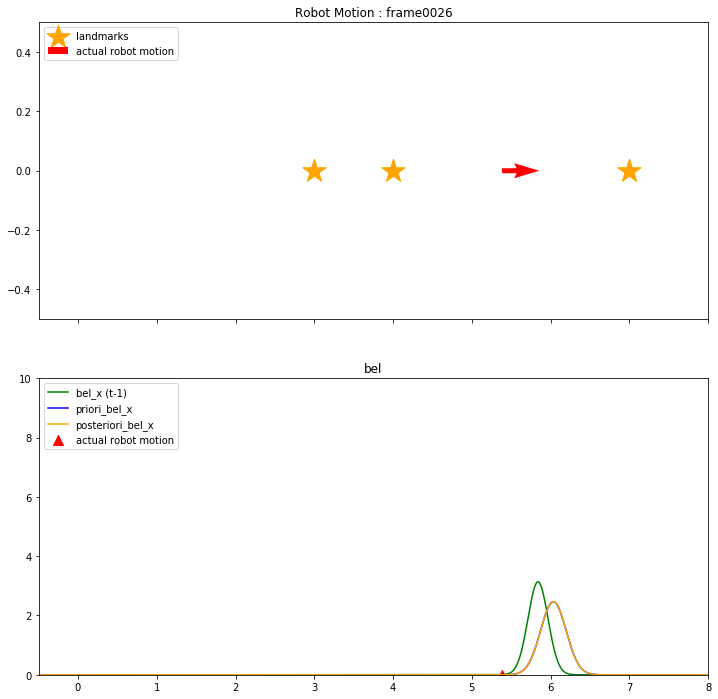

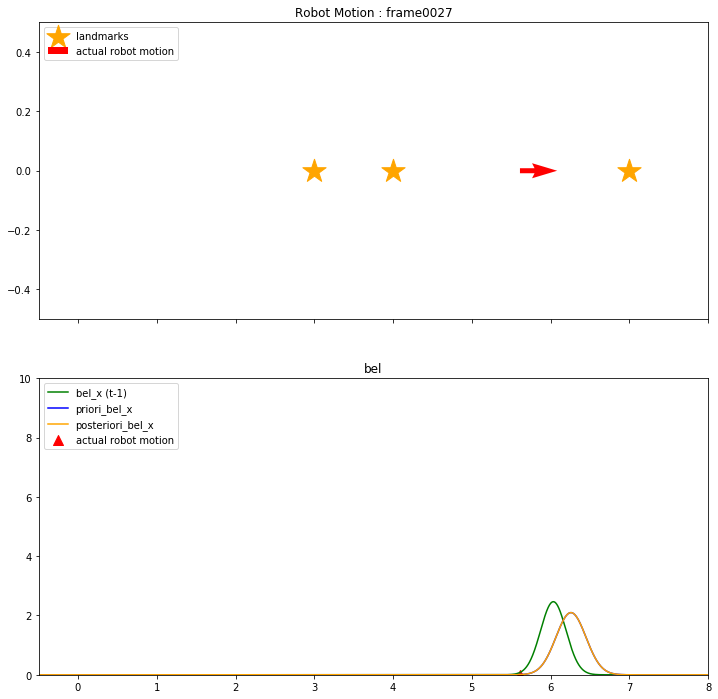

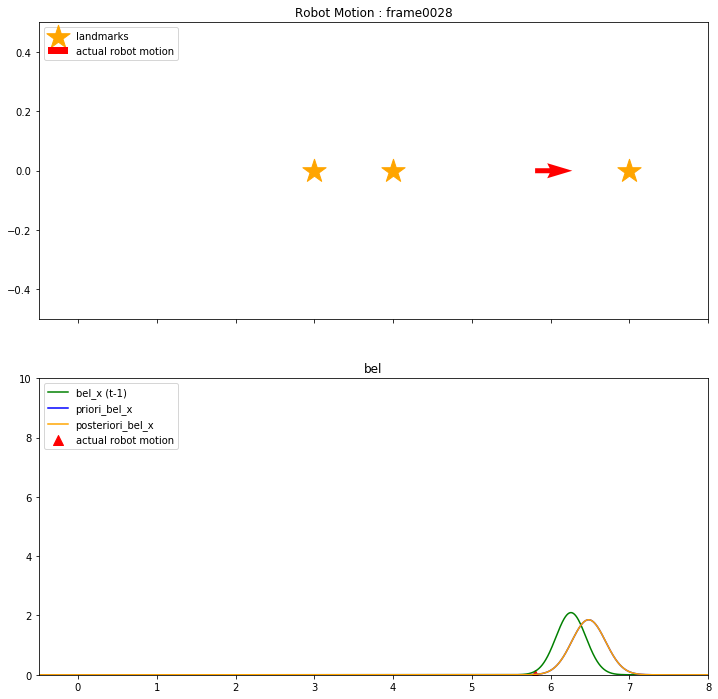

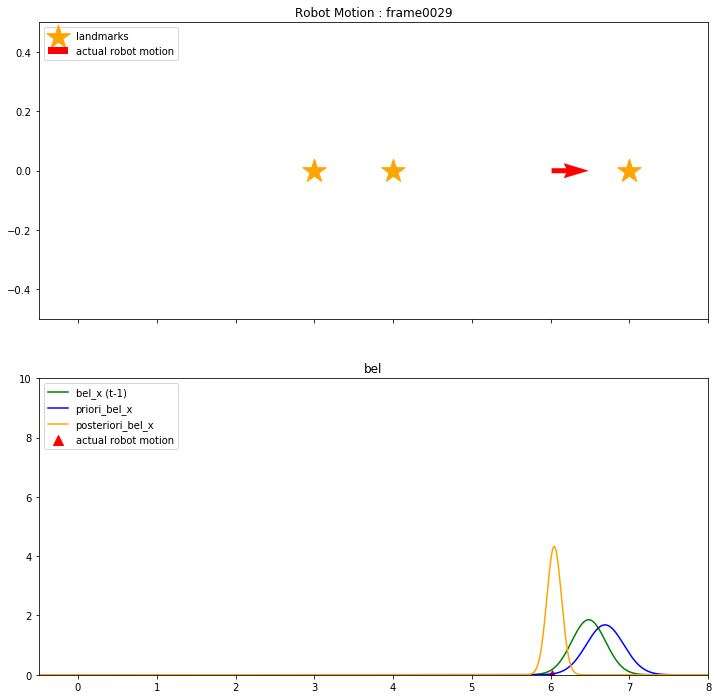

In [8]:
# figureの初期化
plt.close()

# ランドマークの座標を指定
landmarks = Landmarks([3.0, 4.0, 7.0])

# ロボットの座標を指定
robot = Robot(0)

# アニメーション作成の更新処理
def update(i):
    # 新規ウィンドウと座標軸用subplotを用意
    # タイトルは個別につけるので今は指定しない
    fig, (world, graph) = plt.subplots(2, sharex=True, figsize=(12, 12))
    # 座標軸の範囲を指定
    world.set_xlim(-0.5, 8.0)
    world.set_ylim(-0.5, 0.5)
    graph.set_ylim(0.0, 10.0)
    # ランドマークを描画
    landmarks.draw(world)
    # ロボットを移動
    robot.move(0.2)
    # 移動後の位置でランドマークを観測
    obss = robot.observation(landmarks)
    # ロボットを描画
    robot.draw(world, obss)
    robot.draw_graph(graph, obss)
    # タイトルを追加
    world.set_title("Robot Motion : frame{0:04d}".format(i))
    graph.set_title("bel")
    # 左上に凡例を追加
    world.legend(loc='upper left')
    graph.legend(loc='upper left')

# アニメーションの作成
for i in range(0, 30):
    update(i)
    plt.show()